#### Импортируем нужные библиотеки

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive

from scipy.optimize import minimize
from sklearn.metrics import r2_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Прогнозирование поведения клиента (ДЗ)

Привет!

В данном домашнем задании тебе предстоит построить кривые def rate, dlq ratio и clo rate (подробные пункты перечислены ниже). Для выполнения тебе понадобится выборка с данными, которую использовали на семинаре (**data_vintages.csv**), x_score с семинара (**data_scores.csv**) и PD, который ты получил по итогу выполнения предыдущего ДЗ (скор, предсказывающий вероятность выпадения в дефолт за первые 12 месяцев жизни кредита). Не бойся выходить за рамки методов, предлженных в лекции. Главное - не забывай **аргументировать** свой выбор и давать **комментарии** своим действиям.

Удачи!

#### Как будет оцениваться ваша работа:
За это ДЗ ты можешь получить максимум **14 баллов** (10 за обязатеьную часть и 4 за часть со звездочкой). Все пункты весят по-разному, баллы указаны рядом с пунктами. Баллы могут сниматться в случае неполного выполнения задания или отсутствия аргументации.

Задание со зведочкой не обязательно к выполнению.

#### Задачи:

2) Построить кривые CLO rate
    - Построить винтажи CLO ratio (1 балл)
    - Выбрать переменную для разбивки по бакетам (2 балла)
    - Провести анализ поколений (0.5 баллов)
    - Построить винтажи CLO rate (2 балла)
    - Провести анализ на особые точки (0.5 балла)
    - Построить среднее по винтажам для каждого бакета (1 балл)
    - Сгладить кривые (2 балла)
    
3) * Провести анализ на наличие макроэкономического воздействия (4 балла)

В качестве результата по пунктам 2 и 3 приложите текущий ноутбук с названием 'Surname_clo.ipynb'

#### Подгрузим модель из предыдущего задания и получим по ней pd

In [ ]:
import pickle # Извлекаем модель логрега из предыдущего дз

with open('/content/pickle_model.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    my_model = pickle.load(f)

In [ ]:
df_scores_features = pd.read_csv(
                                 '/content/data_scores_and_features.csv',
                                 sep=","
                                 ) # Импортируем данные

In [ ]:
df_scores_features['pd'] = df_scores_features['pd'].str.replace(',','.').astype(float) # Преобразуем колонки pd и x_score к числовому виду
df_scores_features['x_score'] = df_scores_features['x_score'].str.replace(',','.').astype(float)

In [ ]:
df_scores_features.loc[df_scores_features['avg_active_time'] < 0, 'avg_active_time'] = 0 # Те же самые преобразования, что и в предыдущем дз
df_scores_features['avg_active_time'].fillna(0, inplace = True) # Те же самые преобразования, что и в предыдущем дз

df_scores_features['avg_util'].clip(upper = 1.013761, inplace = True) # Те же самые преобразования, что и в предыдущем дз

In [ ]:
df_scores_features[df_scores_features['max_util'].isna()] # Ищем NaN'ы

,user_id,pd,x_score,max_util,avg_util,credits_2y,credits_4y,bad_history_credits_flg,other_util,avg_term,min_term,avg_limit_mortgage,min_limit_mfo,close_balance_amt,soc_dem_score,max_delq_cnt,avg_active_time,last_credit_time_years
32506,109960,0.059484,0.156461,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
68471,131144,0.033228,0.156461,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
93755,143142,0.032949,0.156461,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [ ]:
df_scores_features.drop(index = df_scores_features[df_scores_features['max_util'].isna()].index, inplace = True) # Удаляем выбросы

In [ ]:
good_features = ['max_util',
 'last_credit_time_years',
 'soc_dem_score',
 'other_util',
 'credits_4y',
 'min_limit_mfo',
 'close_balance_amt',
 'avg_limit_mortgage',
 'avg_active_time'] # Отобранные фичи с прошлого дз

df_scores_features['my_pd'] = my_model.predict_proba(df_scores_features[good_features])[:,1]

In [ ]:
df_scores_features['my_pd'] # Вот он

0         0.036947
1         0.020300
2         0.067931
3         0.151244
4         0.055042
            ...   
104815    0.061660
104816    0.128914
104817    0.044130
104818    0.073031
104819    0.039542
Name: my_pd, Length: 104817, dtype: float64

## Кривые CLO rate

#### Выгружаем данные с винтажами

In [ ]:
# В качестве данных для винтажей используй файл с семинара data_vintages.csv

df1 = pd.read_csv(
    '/content/data_vintages1.csv',
    sep=",",
    encoding="cp1251"
)

df2 = pd.read_csv(
    '/content/data_vintages2.csv',
    sep=",",
    encoding="cp1251"
)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df = df1.append(df2) # Преобразуем всё в один dataframe
df.head()

,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg
0,127336.0,19,2019-07-01,2019-07-01,0,0,0,1,0,0.0,0.0,1.0
1,35907.0,16,2019-04-01,2019-04-01,1,0,0,0,1,0.0,0.0,0.0
2,45228.0,21,2019-05-01,2019-04-01,0,0,0,1,0,0.0,0.0,1.0
3,39035.0,23,2019-07-01,2019-07-01,0,0,0,1,0,0.0,0.0,1.0
4,130780.0,19,2019-08-01,2019-07-01,1,0,0,0,1,0.0,0.0,0.0


#### Выгружаем данные со скорами для дальнейшей разбивки на бакеты

In [ ]:
# Тебе понадобятся два скора:
# 1) x_score из файла data_scores.csv
# 2) PD (вероятность дефолта за 12 месяцев), который вы получили в предыдущем ДЗ

df_scores = pd.read_csv(
    '/content/data_scores.csv',
    sep=";",
    encoding="cp1251",
    decimal=',',
    index_col=0
)

df_scores.head(10)

,user_id,pd,x_score
0,9311,0.035025,0.219980
1,155026,0.046279,0.146986
2,17584,0.007221,0.343298
3,156231,0.069679,0.186684
4,123587,0.010402,0.305582
5,125519,0.032667,0.261228
6,123890,0.027963,0.199389
7,82137,0.073694,0.113313
8,55227,0.011746,0.335474
9,124825,0.049237,0.227262


Подменяем pd на my_pd(который получен из предыдущей дз)

In [ ]:
df_scores = df_scores[['user_id', 'x_score']].merge(df_scores_features[['user_id', 'my_pd']], how='left', on='user_id').dropna()

In [ ]:
df_scores.rename(columns = {'my_pd':'pd'}, inplace = True)
df_scores.head(10)

,user_id,x_score,pd
0,9311,0.219980,0.029257
1,155026,0.146986,0.045094
2,17584,0.343298,0.019559
3,156231,0.186684,0.035507
4,123587,0.305582,0.034411
5,125519,0.261228,0.057185
6,123890,0.199389,0.025273
7,82137,0.113313,0.104410
8,55227,0.335474,0.012161
9,124825,0.227262,0.049084


#### Бъем выборку на бакеты и джойним с данными с винтажами

In [ ]:
# Разбей данные на 3 бакета по каждой переменной

df_scores = df_scores.sort_values(['pd'], ignore_index=True)
df_scores['pd_bucket'] = np.minimum(df_scores.index // (df_scores.shape[0]//3),2)
print(df_scores.groupby(['pd_bucket'])['pd'].mean())

df_scores = df_scores.sort_values(['x_score'], ignore_index=True)
df_scores['x_bucket'] = np.minimum(df_scores.index // (df_scores.shape[0]//3),2)
print(df_scores.groupby(['x_bucket'])['x_score'].mean())

df = df.merge(df_scores[['user_id', 'pd_bucket', 'x_bucket', 'pd', 'x_score']], how='left', on='user_id').dropna()
df.head()

pd_bucket
0    0.025958
1    0.048431
2    0.100512
Name: pd, dtype: float64
x_bucket
0    0.133271
1    0.220842
2    0.379455
Name: x_score, dtype: float64


,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg,pd_bucket,x_bucket,pd,x_score
0,127336.0,19,2019-07-01,2019-07-01,0,0,0,1,0,0.0,0.0,1.0,2.0,2.0,0.076850,0.469410
1,35907.0,16,2019-04-01,2019-04-01,1,0,0,0,1,0.0,0.0,0.0,1.0,0.0,0.057408,0.157215
2,45228.0,21,2019-05-01,2019-04-01,0,0,0,1,0,0.0,0.0,1.0,1.0,2.0,0.055483,0.469583
3,39035.0,23,2019-07-01,2019-07-01,0,0,0,1,0,0.0,0.0,1.0,0.0,1.0,0.035253,0.210896
4,130780.0,19,2019-08-01,2019-07-01,1,0,0,0,1,0.0,0.0,0.0,1.0,1.0,0.043985,0.269492


Приводим данные к правильному типу

In [ ]:
df.dtypes

user_id           float64
statement_num      object
gen_month_dt       object
gen_quarter_dt     object
clo_flg             int64
def_flg             int64
dlq_flg             int64
act_flg             int64
prev_clo_flg        int64
prev_def_flg      float64
prev_dlq_flg      float64
prev_act_flg      float64
pd_bucket         float64
x_bucket          float64
pd                float64
x_score           float64
dtype: object

In [ ]:
df['statement_num'] = df['statement_num'].astype(int)
df['gen_month_dt'] = pd.to_datetime(df['gen_month_dt'])
df['gen_quarter_dt'] = pd.to_datetime(df['gen_quarter_dt'])

### Построй винтажи кривой Clo ratio (1 балл)


Clo ratio - доля закрытых счетов:
### $$ CLO ratio_n = \frac{\#CLO_n}{\#cnt_n}$$


In [ ]:
# Выгружаем таблицу

closed_ratio_data = (df.groupby(["gen_quarter_dt", "statement_num"])      # группировка по поколению и месяцу жизни клиента
        .agg({"clo_flg":np.mean})                                         # считаем средний уровень дефолта
        .rename(columns = {"clo_flg": 'closed_ratio'})                    # переименовываем столбец со средними значениями
        .unstack('gen_quarter_dt'))                                       # разворачиваем таблицу, столбцы теперь поколения
closed_ratio_data

closed_ratio                                            
gen_quarter_dt   2019-01-01 2019-04-01 2019-07-01 2019-10-01 2020-01-01
statement_num                                                          
1                  0.051607   0.050059   0.059050   0.084364   0.086394
2                  0.085121   0.076772   0.091212   0.127774   0.125627
3                  0.116670   0.102002   0.116760   0.162143   0.157726
4                  0.144640   0.127153   0.145560   0.196534   0.184094
5                  0.174674   0.155983   0.176187   0.231170   0.209765
6                  0.200581   0.184405   0.208916   0.259184   0.240293
7                  0.229062   0.215255   0.239453   0.282114   0.273139
8                  0.259830   0.241919   0.266399   0.307039   0.304087
9                  0.282529   0.268168   0.290818   0.334231   0.334684
10                 0.312855   0.294069   0.309554   0.359832   0.367078
11                 0.337433   0.316387   0.327092   0.386259   0.395836
12                 0.357382   0.335847   0.345774   0.413128   0.423855
13                 0.381707   0.350256   0.367673   0.436996   0.446533
14                 0.399955   0.367081   0.387613   0.463311   0.466852
15                 0.414305   0.384306   0.410653   0.487207   0.486733
16                 0.428316   0.402161   0.432029   0.508730   0.507849
17                 0.441941   0.420713   0.453332   0.527768   0.527307
18                 0.457152   0.440736   0.473609   0.546481   0.545922
19                 0.476594   0.457645   0.492277   0.562627   0.563520
20                 0.493813   0.478072   0.508924   0.581497   0.579722
21                 0.512037   0.495529   0.525756   0.598722   0.596864
22                 0.534464   0.511352   0.541169   0.616384   0.612576
23                 0.550964   0.527899   0.557403   0.631711   0.625748
24                 0.563642   0.542967   0.571916   0.644282   0.640349

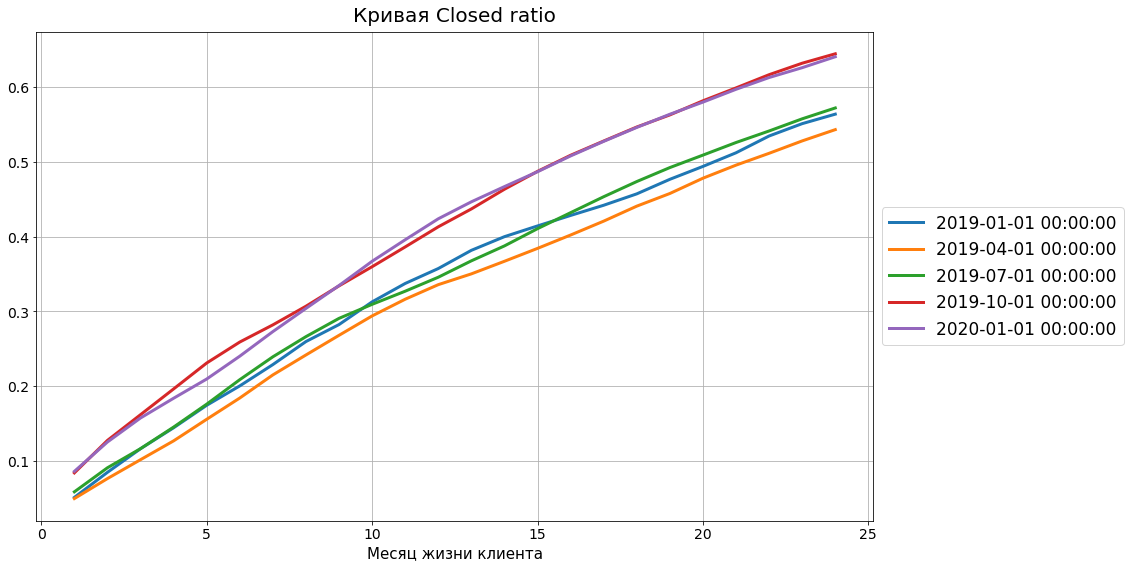

In [ ]:
def plot_clo_ratio_by_generation(df):
    return (df.groupby(["gen_quarter_dt", "statement_num"])
            .agg({"clo_flg":np.mean})
            .rename(columns = {"clo_flg": 'closed_ratio'})
            .unstack('gen_quarter_dt')
            ['closed_ratio']
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3))

# Строим график при помощи pyplot
plot_clo_ratio_by_generation(df)

# Настраиваем параметры отображения графика
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Closed ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

### Выбери переменную, которая делит кривые наилучшим образом (2 балла)

 Из двух скоров (x_score и ваш PD) выбери тот, который разделяет кривые наилучшим образом

#### Разделение кривых по PD
PD - вероятность дефлота (просрочки 4+) за первые 12 платежей по кредиту

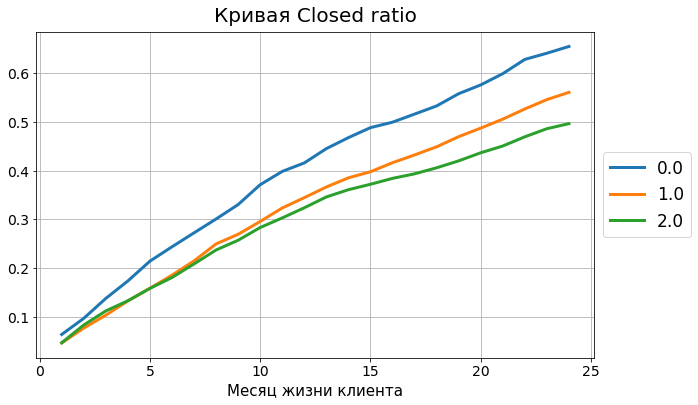

In [ ]:
def plot_clo_ratio_by_bucket(df, bucket):
    return (df.query(''' gen_quarter_dt == '2019-01-01' ''')
            .groupby([bucket, "statement_num"])
            .agg({"clo_flg":np.mean})
            .rename(columns = {"clo_flg": 'closed_ratio'})
            .unstack(bucket)
            ['closed_ratio']
            .plot(ax=None, figsize=(10, 6), grid=True, lw = 3))

plot_clo_ratio_by_bucket(df, 'pd_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Closed ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Разделение получилось плохим. Посмотрим, что будет по X

#### Разделение кривых по переменной X

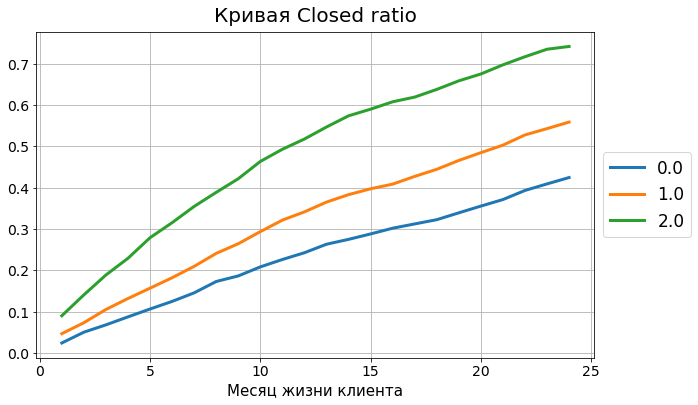

In [ ]:
plot_clo_ratio_by_bucket(df, 'x_bucket')

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Closed ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Вывод: Разделение на втором графике(X_score) значительно лучше. Масштаб у графиков почти одинаковый и видно, что на втором линии расположены немного дальше друг от друга. Если подойти к вопросу строго, можно рассмотреть расстояние между линиями на 15, 20 месяцах и сравнить(у X_score оно будет больше). Кроме этого X_score это скор, предсказывающий досрочное закрытие и ожидаемо, что он будет связан с Clo. **Итог:** выбираем X_score.

### Анализ странных поколений (0.5 баллов)

Отрисуй распределение данных во времени в разбивке по выбранной перменной

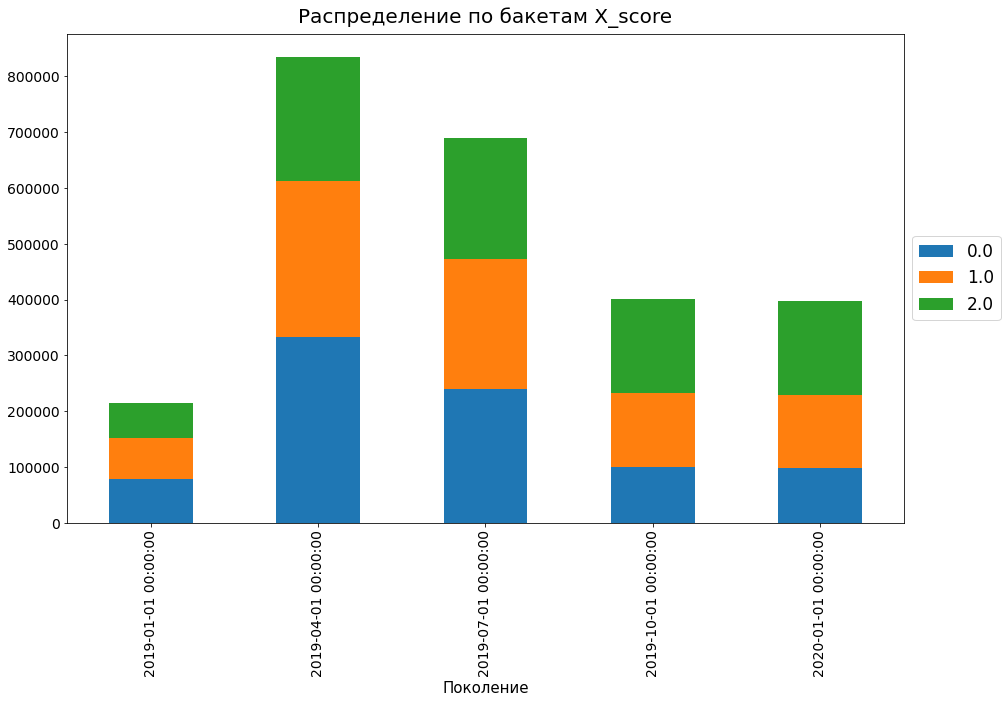

In [ ]:
def plot_distribution(df, bucket):
    return pd.pivot_table(df, index=[bucket], columns='gen_quarter_dt',          # делаем сводную таблицу и транспонируем ее
                values="user_id",
                aggfunc=np.count_nonzero, fill_value=0)\
               .T\
               .plot(kind='bar', stacked=True, figsize=(15, 9))                    # Рисуем график распределения столбиками

plot_distribution(df, 'x_bucket')

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Распределение по бакетам X_score", size=20, verticalalignment='bottom')
plt.xlabel("Поколение", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Вывод: В первом поколении меньше наблюдений, чем в остальных, тем не менее их достаточно много, поэтому оставляем. В остальных поколениях все в порядке.



### Кривые СLO Rate в разбивке по бакетам

$CLO_n$ - количество счетов, закрывшихся в месяц $n$

$ACT_{n-1}$ - количество активных счетов (в просрочке 0-3) в месяц $n-1$

## $$ CLO Rate_n = \frac{\#CLO_n}{\#Act_{n-1}} $$

Реализуй функцию, которая отрисовывает винтажи CLO rate в разбивке по бакетам

In [ ]:
%matplotlib inline
# Выгружаем таблицу c винтажами

closed_rate_data = df.eval('clo_new_flg = clo_flg * prev_act_flg', inplace=False)\
    .groupby(["gen_quarter_dt", 'x_bucket', "statement_num"])\
    .agg({"clo_new_flg":np.sum, "prev_act_flg":np.sum, "user_id":np.count_nonzero})\
    .rename(columns = ({"clo_new_flg":'clo_cnt', "prev_act_flg":'prev_act_cnt', "user_id":"cnt"}))\
    .eval('closed_rate = clo_cnt / prev_act_cnt', inplace=False)


# Делаем список бакетов

buckets = df['x_bucket'].drop_duplicates().sort_values(ascending = True)


def plot_clo_rate_by_generation(x_bucket):
# Строим график, который зависит от бакета

    cur_df = closed_rate_data.query('x_bucket == ' + str(x_bucket))
    (cur_df.unstack('gen_quarter_dt')
            ['closed_rate']
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3))
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая Closed rate, x_bucket = " + str(x_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)


# Отображаем его при помощи ipywidget, чтобы получить интерактивность

vintages_graph = interactive(plot_clo_rate_by_generation, x_bucket = buckets)
vintages_graph

interactive(children=(Dropdown(description='x_bucket', options=(0.0, 1.0, 2.0), value=0.0), Output()), _dom_cl…

#### Выводы: Синий график(поколение 2019-01-01) немного зашумляем наблюдения во 2 бакете. Исключим его из рассмотрения в этом бакете.

### Особые точки (0.5 баллов)
#### Особая точка в первый месяц. Объяснить можно тем, что некоторые клиенты(а их около 5-10% в зависмости от периода и бакета) возвращают деньги в банк почти сразу после открытия кредита. Из-за этого значение в 1 месяц больше чем в остальные. Эту особую точку не стоит исключать, т.к. это не выброс и её появление легко можно объяснить.

#### Также есть особая точка на 22 месяце в 0 и 1 бакетах, скорее всего, это выброс. Её нужно исключить.


### Среднее по бакетам (1 балл)
Выбери один из способой нахождение средней кривой (возможные способы указаны в лекции). Обоснуй свой выбор.

Реализуй функцию построения среднего. Веса возьмем пропорционально количеству наблюдений.

In [ ]:
def average(x):
    x = np.array(x)
    if (len(x) == 3): # Случай 0-1 бакета в 22 месяц
        return np.average(x, weights=[8, 7, 4])
    if (len(x) == 4): # Случай 2 бакета
        return np.average(x, weights=[8, 7, 4, 4])
    if (len(x) == 5): # Случай 0-1 бакета, кроме 22 месяца
        return np.average(x, weights=[2, 8, 7, 4, 4])



In [ ]:
# Исключаем "странные" поколения

exception_query = ''' ~(((gen_quarter_dt == '2019-01-01') & (x_bucket == 2)) or ((gen_quarter_dt == '2019-01-01' or gen_quarter_dt == '2019-10-01') & (x_bucket != 2) & (statement_num == 22))) '''
closed_rate_data.query(exception_query, inplace = True)

# Реализация расчета среднего

closed_rate_mean = closed_rate_data.groupby(['statement_num', 'x_bucket', 'gen_quarter_dt']).agg({'closed_rate':np.mean})\
    .groupby(['statement_num', 'x_bucket']).agg({'closed_rate':average})\
    .rename(columns = {'closed_rate':'Среднее'}) # Тут я решил взять взвешенное среднее

buckets = df['x_bucket'].drop_duplicates()

# Построй графики винтажей и среднего

def plot_clo_rate_mean(x_bucket):
    vintages_graph = closed_rate_data.query('x_bucket == ' + str(x_bucket))\
            .unstack('gen_quarter_dt')\
            ['closed_rate']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)                                             # график винтажей
    (closed_rate_mean.query('x_bucket == ' + str(x_bucket))
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))  # Подаем график винтажей в ось другого,
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')                                 # чтобы отобразить их вместе
    plt.title("Кривая Closed rate, x_bucket = " + str(x_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

vintages_graph = interactive(plot_clo_rate_mean, x_bucket = buckets)
vintages_graph

interactive(children=(Dropdown(description='x_bucket', options=(2.0, 0.0, 1.0), value=2.0), Output()), _dom_cl…

Графики немного смещены в зависимости от поколения и с помощью взвешенного среднего и правильного выбора коэффициентов(веса берем пропорционально количеству наблюдений в поколении) можно получить кривую, которая будет хорошо отражать среднюю картину.

### Сглаживание средних кривых (2 балла)

Рассмотри несколько функций для сглаживания кривой (можешь взять готовые из семинара, либо реализовать свои).

Тут я рассматриваю 1 бакет

In [ ]:
def linear_approximation(df, start=1, finish=24):
    df_res = pd.DataFrame(df)
    df_res['Линейная функция'] = df['Среднее']                                                # Копируем средние значения
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], 1)  # Коэффициенты уравнения прямой
    linear_coeff = np.poly1d(linear_coeff)                                                    # Превращаем коэффициенты в функцию
    df_res.loc[start:finish, 'Линейная функция'] = linear_coeff(np.arange(start, finish+1))   # Записываем приближение
    df_res.loc[finish+1:, 'Линейная функция'] = linear_coeff(finish+1)                        # Продолжаем кривую константой
    return df_res

# Делаем аппроксимацию

df_linear = closed_rate_mean.query('x_bucket == 1').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 5, 15)

In [ ]:
def polynom_approximation(df, start=1, finish=20, degree = 1):
    df_res = pd.DataFrame(df)
    df_res['Полином'] = df['Среднее']
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], degree)  # Здесь произвольная степень
    linear_coeff = np.poly1d(linear_coeff)
    df_res.loc[start:finish, 'Полином'] = linear_coeff(np.arange(start, finish+1))
    df_res.loc[finish+1:, 'Полином'] = linear_coeff(finish+1)
    return df_res


# Делаем полиномиальную аппроксимацию
df_polynom = polynom_approximation(df_linear, 5,24,2)

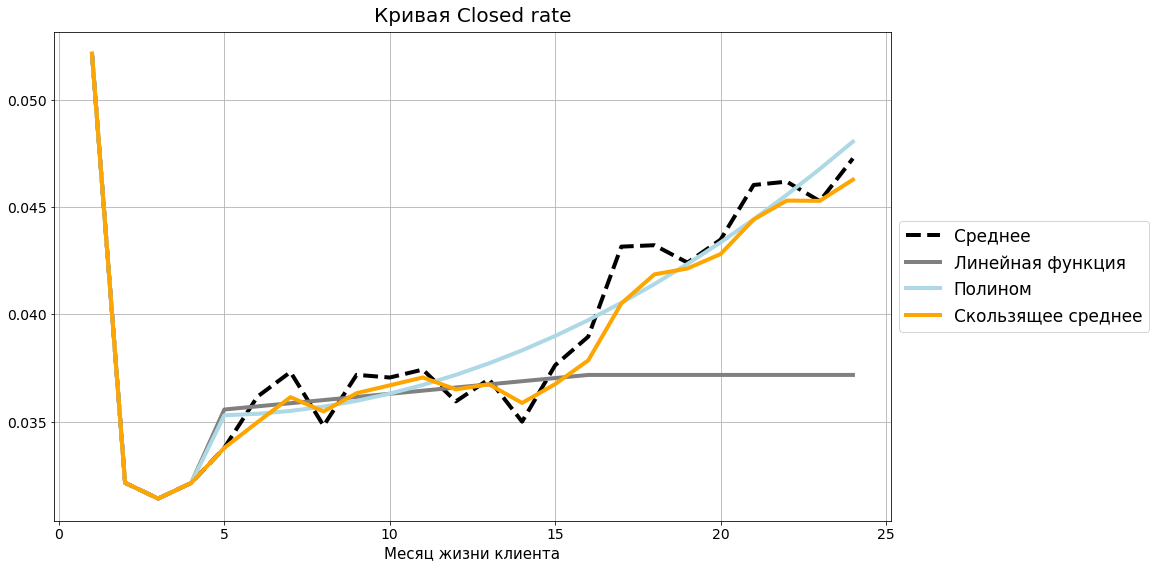

In [ ]:
def exponential_smoothing(df, start, finish, alpha):
    df_res = pd.DataFrame(df)
    result = [df_res.loc[i,'Среднее'] for i in np.arange(1,start+1)]                              # Начальные значения копируем
    for n in range(start, len(df_res['Среднее'])):
        result.append(float(alpha * df_res.loc[n + 1, 'Среднее'] + (1 - alpha) * result[n-1]))    # Делаем сглаживание
    df_res['Скользящее среднее'] = result
    return df_res

# Строим экспоненциальное скользящее среднее с alpha = 0.25
df_smooth = exponential_smoothing(df_polynom, 5,24, 0.5)

# Строим получившиеся графики
plt.figure(figsize=(15, 9))
df_smooth['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_smooth['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_smooth['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)
df_smooth['Скользящее среднее'].plot(grid=True, color = 'Orange', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Closed rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

In [ ]:
def approximation(df, start=1, finish=20, degree = 1):
    df_res = pd.DataFrame(df)
    df_res['Полином'] = df['Среднее']
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], degree)  # Здесь произвольная степень
    linear_coeff = np.poly1d(linear_coeff)
    df_res.loc[start:finish, 'Полином'] = linear_coeff(np.arange(start, finish+1))
    df_res.loc[finish+1:, 'Полином'] = linear_coeff(finish+1)
    return df_res

Линейная функция – плохо приближает «хвост»

Полином – хорошо приближает среднее

Скользящее среднее – подстраивается под колебания кривой и, кажется, это не очень хорошо

#### Вывод: В данном случае победил полином – он хорошо предсказывает поведение среднего, но в отличии от скользящего среднего более устойчив к колебаниям.

Точек, к которым сглаживание не применялось, не было. Единственная значимая особая точка это 1-й месяц, но её появление закономерно.  

#### На всякий случай убедимся, что наше сглаживание подходит и для других бакетов

**Bucket 0**

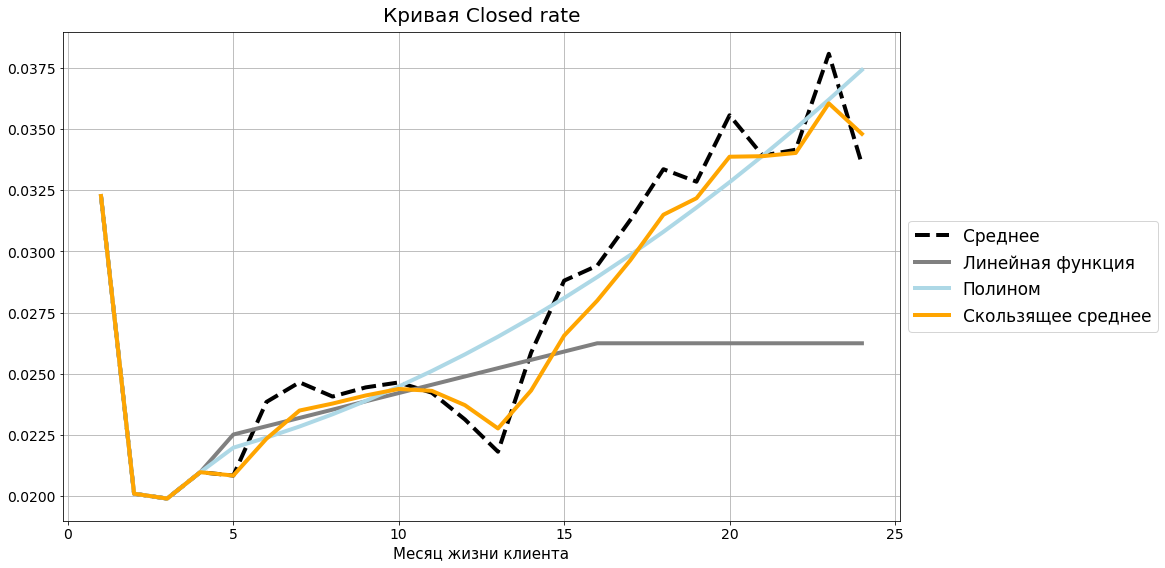

In [ ]:
df_linear = closed_rate_mean.query('x_bucket == 0').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 5, 15)

df_polynom = polynom_approximation(df_linear, 5,24,2)

df_smooth = exponential_smoothing(df_polynom, 5,24, 0.5)

# Строим получившиеся графики
plt.figure(figsize=(15, 9))
df_smooth['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_smooth['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_smooth['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)
df_smooth['Скользящее среднее'].plot(grid=True, color = 'Orange', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Closed rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

**Bucket 2**

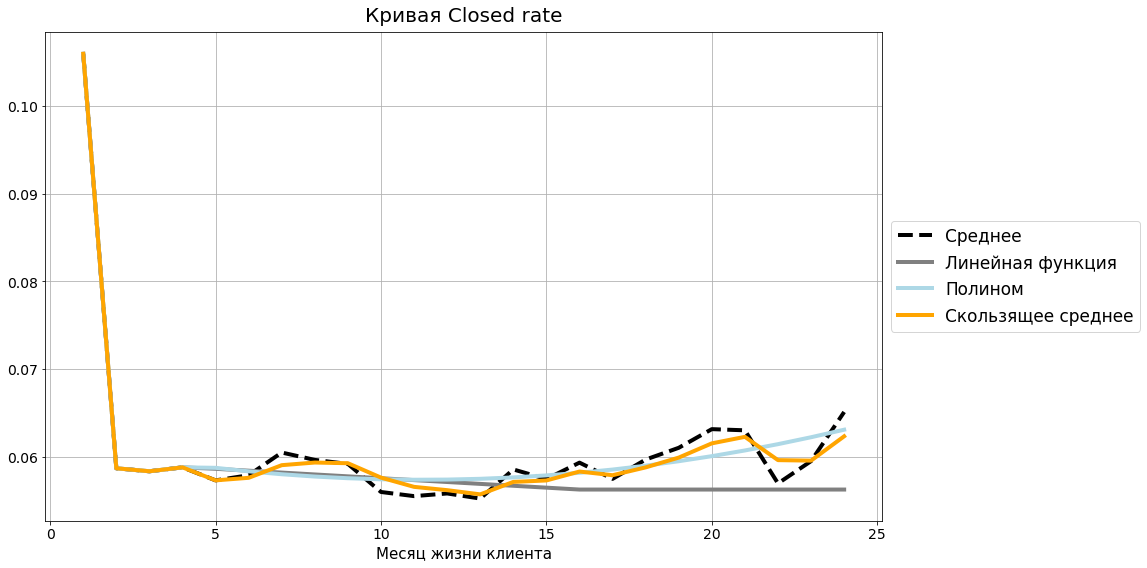

In [ ]:
df_linear = closed_rate_mean.query('x_bucket == 2').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 5, 15)

df_polynom = polynom_approximation(df_linear, 5,24,2)

df_smooth = exponential_smoothing(df_polynom, 5,24, 0.5)

# Строим получившиеся графики
plt.figure(figsize=(15, 9))
df_smooth['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_smooth['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_smooth['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)
df_smooth['Скользящее среднее'].plot(grid=True, color = 'Orange', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Closed rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Тут все нормально. Полином неплохо справляется.

### Отрисуй сглаженные кривые по всем трем бакетам PD

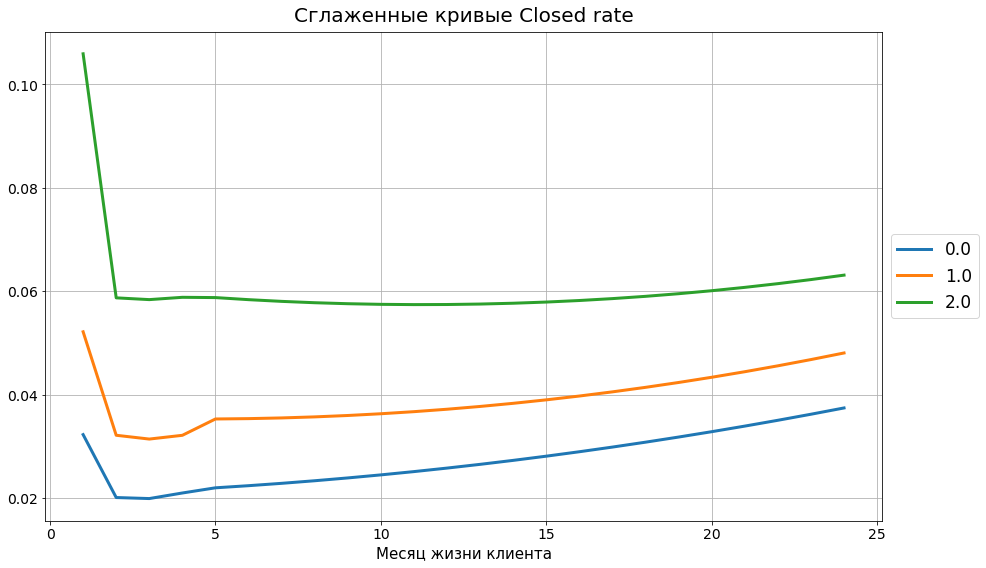

In [ ]:
# Запоминаем набор бакетов и заводим пустой датафрейм под результат

buckets = df['x_bucket'].drop_duplicates().sort_values()
df_smooth_result = pd.DataFrame()

# Далем полиномиальное сглаживание для каждого бакета
for bucket in buckets:
    df_temp = closed_rate_mean.query('x_bucket == ' + str(bucket)).reset_index().set_index(['statement_num'])
    df_smooth_result[str(bucket)] = approximation(df_temp, 5,24,2)['Полином']

# Строим итоговый график
df_smooth_result.plot(figsize=(15, 9), grid=True, lw = 3)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Сглаженные кривые Closed rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

## (Задача со звездочкой)
## Макроэкономические воздействие (4 балла)

#### Есть ли в винтажах CLO rate макроэкономическое воздействие? Если да, то предположи какое событие его вызвало и почему?
#### В случае наличия внешнего влияния
#### 1) Разложи кривые на внешнее воздействие и созревание кривых
#### 2) Отрисуй график внешнего воздествия
#### 3) Отрисуй вычищенные винтажи Clo rate в разбивке по бакетам
#### 4) Посчитай среднее для этих бакетов и реализуй сглаживание

**Есть определенное воздействие около мая 2020 года**, графики в этот момент времени немного проседают(особенно на 1 и 2 бакетах). Думаю, это вызвано ковидом и локдаунами, из-за которых многие потеряли работу. Видимо, в этот момент времени людям стало тяжело закрывать кредиты, поэтому мы увидели просадку.

**Также можно увидеть рост возвратов около декабря 2020 года**. По идее, это время когда ковидные ограничения стали более мягкими + тогда было небольшое восстановление деловой активности. Наверно, часть людей, у которых появилась возможность закрыть кредит воспользовались ей.


#####Идея разложения.

Сделаем обозначения:

$t$  - календарное время;

$n$  - номер поколения;

$(t−n)$  - месяц жизни клиента;


$D(t,n)$  - значения исследуемой кривой (Closed rate) в месяц  $t$  для поколения номер  $n$ ;

$E(t)$  - внешние воздействия, которые зависят только от календарного времени  $t$ ;

$M(t−n)$  - кривая созревания, которая зависит только от месяца жизни клиента  $(t−n)$ .


Будем предполагать, что в идеальном случае существует разложение
$$D(n,t)=E(t)M(t−n)$$


Для поиска данного разложения будем минимизировать функционал
$$ F(E,M)=\sum_{n,t}{(D(t,n)−E(t)M(t−n))}^2 \to \min_{E,M} $$

где  $E={E(t),t>0}$, $M={M(t−n),t−n>0}$

#### Функции, которые реализую разложение матрицы

In [ ]:
def curve_build(data,
                feature,
                generation = 'generation_quart',
                statement_num = 'statement_num',
                group_label = '1'):

    """Вспомогательная функция для построения разложения в рамках одного бакета

    **Аргументы**
    data : pandas.DataFrame
        таблица с данными
    feature: str
        название поля с исследуемой переменной
    generation : datetime
        название поля с поколениями
    where : str
        условие, которым мы ограничиваем выборку
    statement_num : int
        название поля с номером месяца жизни клиента
    group_label : str
        название поля группы
    **Результат**
    dictionary : dict
    """

    df_query = data.sort_values([generation, statement_num]).reset_index()

    # Рассчитываем количество поколений и тому подобное
    generation_min = df_query[generation].min()
    gen_cnt = df_query[statement_num].max()

    # Преобразуем Dataframe в набор векторов
    values = np.array(df_query[feature])
    tab_size = df_query[feature].count()
    st_nums = np.array(df_query[statement_num] - 1)
    dates = np.array([0 for i in range(tab_size)])

    for i in range(tab_size):
         dates[i] = df_query.loc[i,generation].year * 12 + df_query.loc[i,generation].month -\
            generation_min.year * 12 - generation_min.month + df_query.loc[i,statement_num] - 1

    # Определяем функционал, который будем минимизировать

    def r_square(x):
        temp = 0
        for i in range(tab_size):
            if dates[i] >= 0:
                temp += (values[i] - x[dates[i]] * x[st_nums[i] + gen_cnt])**2
        return temp

    # Задаем callback для отслеживания прогресса минимизации
    def callbackF(Xi):
        global Nfeval
        print('%d  %.6f' % (Nfeval, r_square(Xi)))
        Nfeval += 1

    # Задаем начальное приближение в виде массива с нулевыми значениями

    x0 = np.array([0 for i in range(2*gen_cnt)])                                # Внешние воздействия

    # Численная минимизация

    print('Initial %.6f' % (r_square(x0)))
    res0 = minimize(r_square, x0, tol=1e-6, callback=callbackF, method='Powell', options = {'disp': False, 'maxiter': 1000})

    # Задаем датафрейм с внешними воздействиями
    external_data = pd.DataFrame({'month_dt': [generation_min + pd.DateOffset(months = i) for i in range(gen_cnt)],
                             group_label: res0.x[:gen_cnt]})

    # Нормируем внешние воздействия таким образом, чтобы в среднем они равнялись единице.
    ext_mean = external_data[external_data['month_dt'] > generation_min + pd.DateOffset(months = 6)][group_label].mean()
    external_data[group_label] = external_data[group_label] / ext_mean

    # И умножаем на полученный коэффициент кривые созревания

    maturation_array = np.transpose([res0.x[gen_cnt:2* gen_cnt] * ext_mean]).flatten()
    maturation_data = pd.DataFrame(data = {group_label: maturation_array, \
                                           'statement_num': np.arange(1,maturation_array.size + 1)})

    df_fitted = df_query.merge(right=external_data, on = 'month_dt')
    df_fitted['fitted_feature'] = df_fitted[feature] / df_fitted[group_label]

    # Формируем словарь c итоговыми данными
    res = {'res0': res0,
          'external_data': external_data,
          'maturation_data': maturation_data,
          'df_fitted': df_fitted}
    return res


def decomposition(df,
                  generation = 'generation_month',
                  group = 'bucket',
                  statement_num = 'statement_num',
                  feature = 'feature',
                  optimization_query = ''):
    """Винтажи исследуемой переменной по календарному времени

    **Аргументы**
    df : pandas.DataFrame
        таблица с данными
    generation : datetime
        название поля с поколениями
    group : str
        название поля с бакетами
    statement_num : int
        название поля с номером выписки
    feature: str
        название поля с исследуемой переменной
    optimization_query: str
        ограничение выборки для оптимизации
    **Результат**
    dictionary : dict
    """

    # Разбираемся со случаем пустых аргументов

    if optimization_query == '':
        df_query = pd.DataFrame(df)
    else:
        df_query = df.query(optimization_query)

    timedelta = df_query[statement_num].apply(lambda x: pd.DateOffset(months=x-1))
    df_query['month_dt'] = df_query[generation] + timedelta

      # Формируем список бакетов

    df_query.sort_values(by = [group], inplace = True)
    groups = pd.Series(df_query[group].drop_duplicates())

    # Запускаем цикл по бакетам
    i = 0
    for g in groups:
        df_temp = df_query[df_query[group] == g]
        print(group + ' = ' + str(g))

        # Строим разложение для одного бакета
        res = curve_build(df_temp,
                          feature = feature,
                          generation = generation,
                          statement_num = statement_num,
                          group_label = str(g)
                         )
        df_fitted_temp = pd.DataFrame(res['df_fitted'])
        df_fitted_temp[group] = g

        # Если первый шаг в цикле, то формируем датафреймы из результатов минимизации
        if i == 0:
            external_data = pd.DataFrame(res['external_data'])[['month_dt', str(g)]]
            maturation_data = pd.DataFrame(res['maturation_data'])[[statement_num, str(g)]]
            df_fitted = pd.DataFrame(df_fitted_temp)
        # Если шаг не первый, то дописываем столбцы в результаты
        else:
            external_data = external_data.merge(right = res['external_data'], on = ['month_dt'])
            maturation_data = maturation_data.merge(right = res['maturation_data'], on = [statement_num])
            df_fitted = pd.concat([df_fitted, df_fitted_temp])
        i+=1

    res_multiple = {
                    'external_data': external_data,
                    'maturation_data': maturation_data,
                    'fitted_data': df_fitted
                   }
    return res_multiple

#### Применим функцию к нашим данным

In [ ]:
# Подготавливаем данные

clo_rate = df.eval('clo_new_flg = clo_flg * prev_act_flg', inplace=False)\
    .groupby(["x_bucket","gen_month_dt", "statement_num"], as_index=False)\
    .agg({"clo_new_flg":np.sum, "prev_act_flg":np.sum, "user_id":np.count_nonzero})\
    .rename(columns = ({"clo_new_flg":'clo_cnt', "prev_act_flg":'prev_act_cnt', "user_id":"cnt"}))\
    .eval('closed_rate = clo_cnt / prev_act_cnt', inplace=False)

# Счетчик итераций
Nfeval = 0

# Проводим разложение кривых
res = decomposition(clo_rate,
                       generation = 'gen_month_dt',
                       group = 'x_bucket',
                       statement_num = 'statement_num',
                       feature = 'closed_rate')

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimelike.py:1190: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,


x_bucket = 0.0
Initial 0.290046
0  0.126390
1  0.119996
2  0.119807
3  0.119738
4  0.119702
5  0.119682
6  0.119640
7  0.119629
8  0.119301
9  0.119194
10  0.118636
11  0.118413
12  0.117466
13  0.117000
14  0.114735
15  0.113164
16  0.103348
17  0.091791
18  0.058677
19  0.045541
20  0.037300
21  0.033300
22  0.031129
23  0.028258
24  0.028031
25  0.027842
26  0.027167
27  0.027147
28  0.027137
29  0.027131
30  0.027128
31  0.027126
32  0.027124
33  0.027121
34  0.027121
35  0.027120
36  0.027120
37  0.027118
38  0.027118
39  0.027114
40  0.027112
41  0.027082
42  0.027073
43  0.026851
44  0.026760
45  0.023102
46  0.022120
47  0.013346
48  0.012629
49  0.012255
50  0.012018
51  0.011856
52  0.011412
53  0.011384
54  0.011369
55  0.011361
56  0.011357
57  0.011354
58  0.011348
59  0.011347
60  0.011347
61  0.011347
62  0.011346
63  0.011346
64  0.011346
65  0.011346
x_bucket = 1.0
Initial 0.577154
66  0.214540
67  0.204159
68  0.203657
69  0.203436
70  0.203325
71  0.203263
72  0.2031

#### Получившиеся кривые внешних воздействий

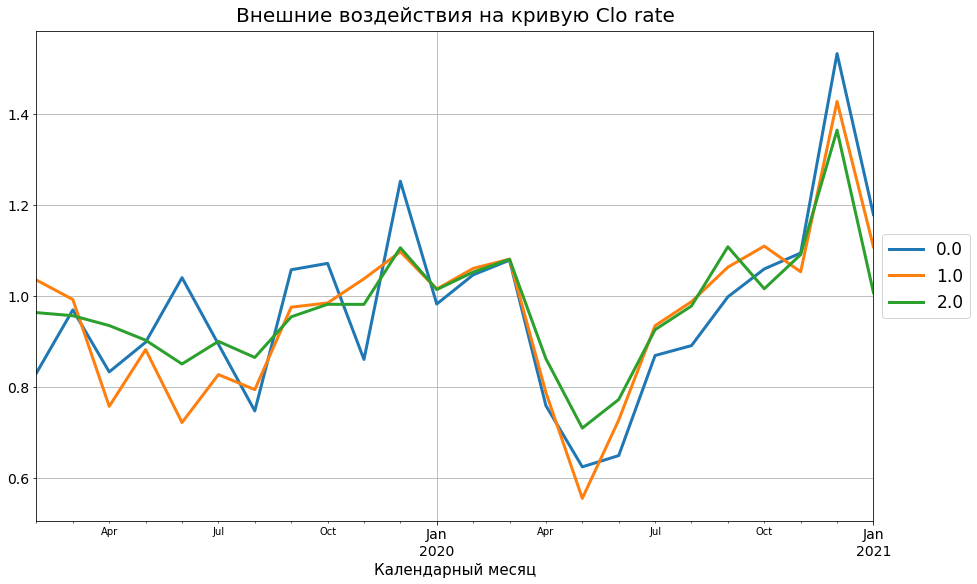

In [ ]:
res['external_data'].set_index('month_dt')\
                    .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Внешние воздействия на кривую Clo rate", size=20, verticalalignment='bottom')
plt.xlabel("Календарный месяц", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Кривые Clo rate, вычищенные от внешних воздействий

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


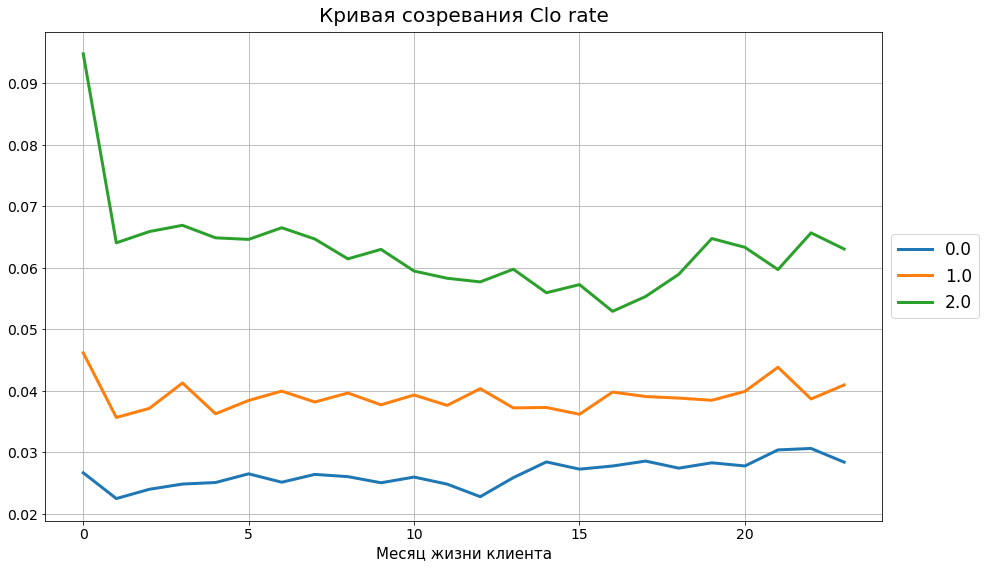

In [ ]:
res['maturation_data'].drop('statement_num', 1).plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая созревания Clo rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Вычищенные кривые в разбивке по поколениям

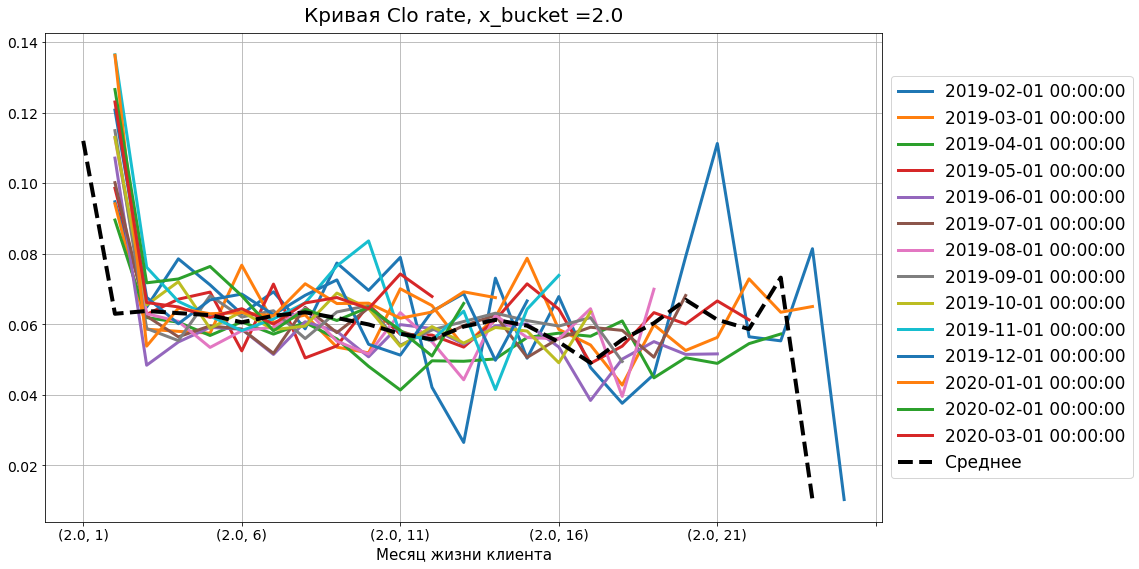

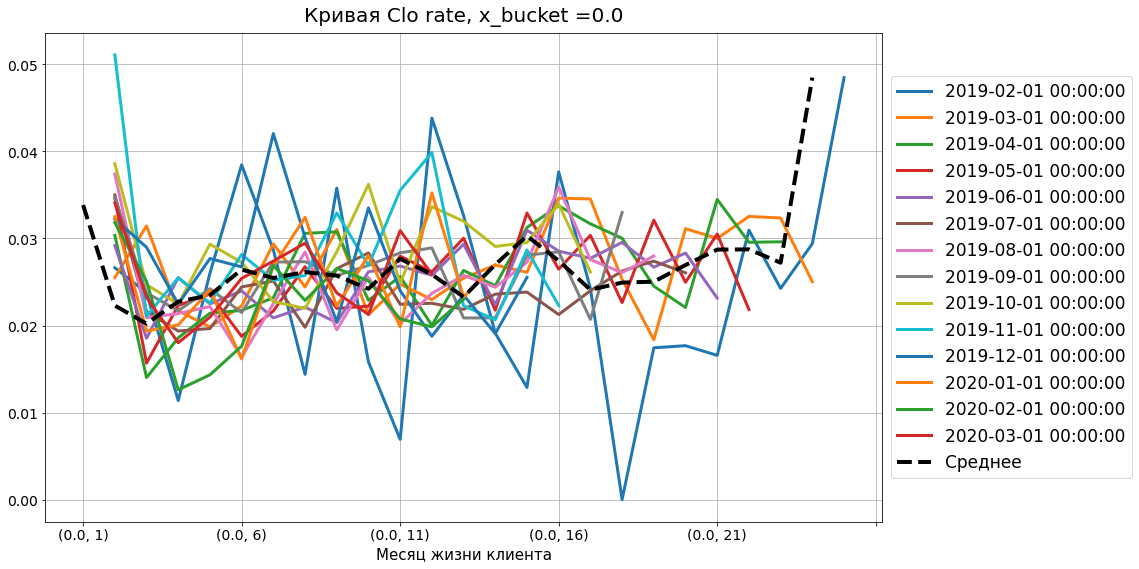

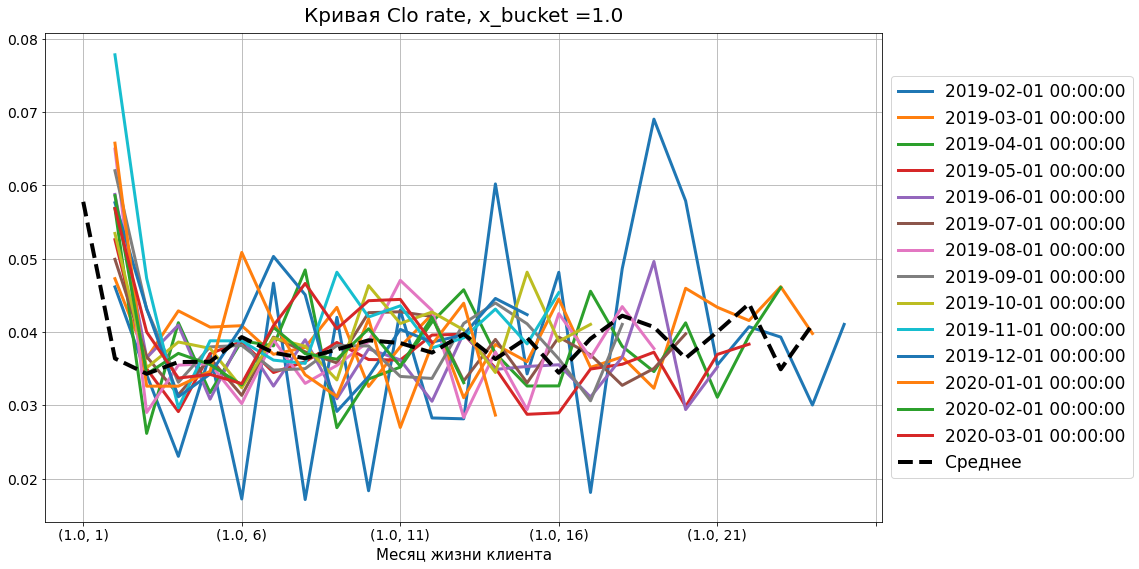

In [ ]:
# Исключаем "странные" поколения

exception_query = ''' ~(((gen_month_dt == '2019-02-01'))) ''' # Это поколение вносит шум
#res['fitted_data'].query(exception_query, inplace = True)

# Считаем среднее

clo_rate_mean = res['fitted_data'].groupby(['x_bucket', 'statement_num'])\
    .agg({'fitted_feature':np.mean})\
    .rename(columns = {'fitted_feature':'Среднее'})   # тут берем обычное среднее(хотя можно было взять и взвешенное)


buckets = df['x_bucket'].drop_duplicates()

# Строим графики винтажей и среднего

def plot_clo_rate_mean(x_bucket):
    vintages_graph = res['fitted_data'].query('x_bucket == ' + str(x_bucket))\
            .groupby(["gen_month_dt", "statement_num"])\
            .agg({"fitted_feature":np.sum})\
            .unstack('gen_month_dt')\
            ['fitted_feature']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)                                             # график винтажей
    (clo_rate_mean.query('x_bucket == ' + str(x_bucket))['Среднее']
             .plot( figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))  # Подаем график винтажей в ось другого,
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')                                 # чтобы отобразить их вместе
    plt.title("Кривая Clo rate, x_bucket =" + str(x_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

for i in buckets:
    plot_clo_rate_mean(i)

### Найдем лучшую функцию для сглаживания кривых

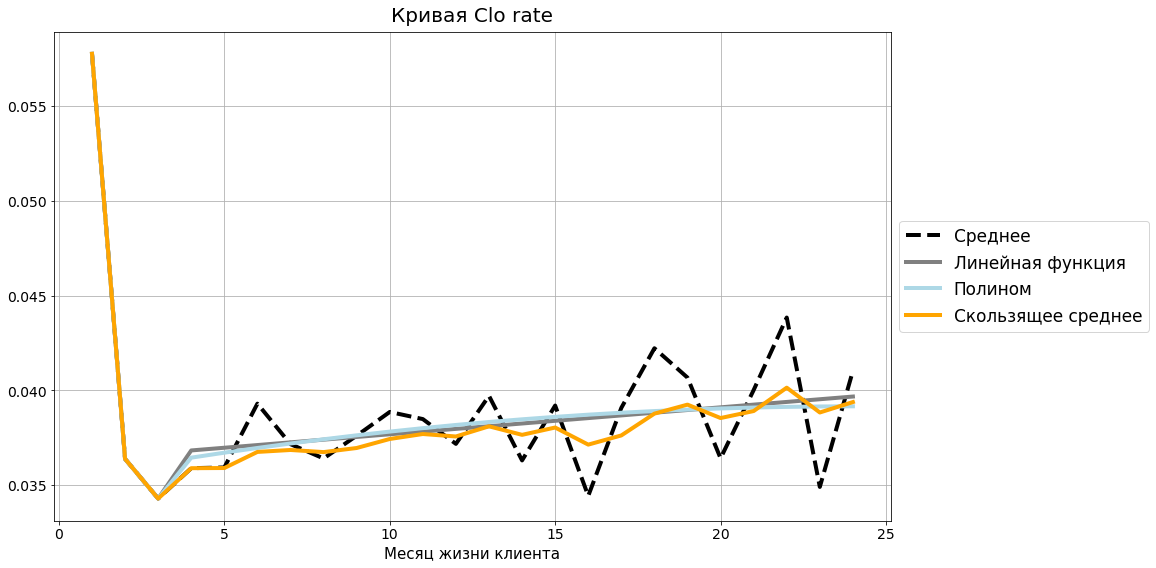

In [ ]:
df_linear = clo_rate_mean.query('x_bucket == 1').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 4, 23)
df_polynom = polynom_approximation(df_linear, 4,23,2)
df_smooth = exponential_smoothing(df_polynom, 4,23, 0.25)

# Строим получившиеся графики
plt.figure(figsize=(15, 9))
df_smooth['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_smooth['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_smooth['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)
df_smooth['Скользящее среднее'].plot(grid=True, color = 'Orange', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Clo rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Для приближения воспользуемся полиномом и сгладим все кривые

Полином - потому что он более устойчив к колебаниям и почти не учитывает выбросов в правой части хвоста(она рассчитана по первым поколениям и из-за малого количества наблюдений не показательна)

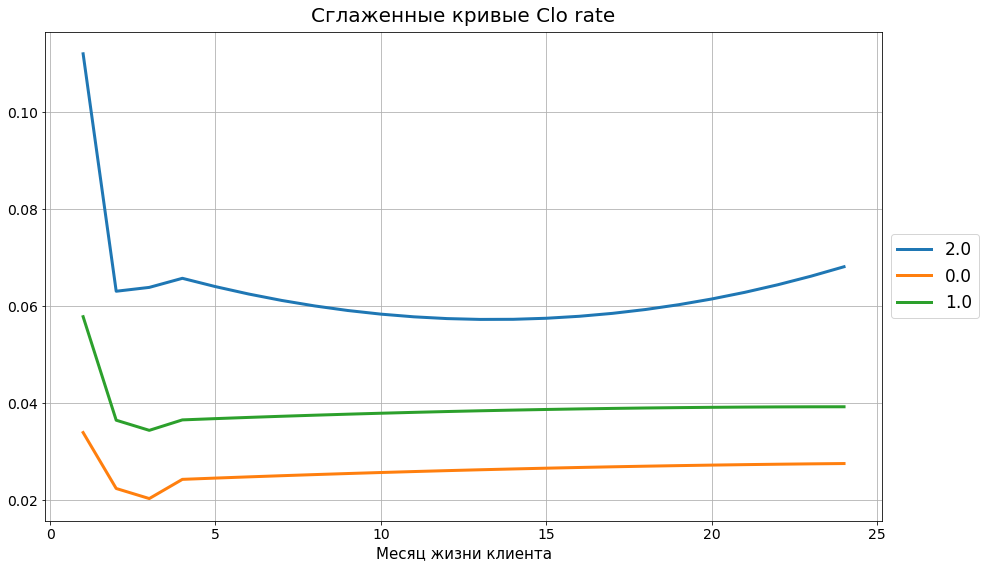

In [ ]:
# Запоминаем набор бакетов и заводим пустой датафрейм под результат

buckets = df['x_bucket'].drop_duplicates()
df_smooth_result = pd.DataFrame()

# Далем полиномиальное сглаживание для каждого бакета
for bucket in buckets:
    df_temp = clo_rate_mean.query('x_bucket == ' + str(bucket)).reset_index().set_index(['statement_num'])
    df_smooth_result[str(bucket)] = polynom_approximation(df_temp, 4,23,2)['Полином']

# Строим итоговый график
df_smooth_result.plot(figsize=(15, 9), grid=True, lw = 3)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Сглаженные кривые Clo rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)